## Assignment 1: Bayesian Decision Theory and Parametric Estimation

Assigment done by:

- Ahumada, Santiago | github: @santiagoahl

- Mora, David | github: @DavidFM43

## Table of contents

>[Library Import]()

>[1st Point]()

>>[a) Data Import]()
>>[b) X and y arrays]()

>>[c) Train & Test split]()
>>[d) Univariate Gaussian Classifier for each attribute]()

>>>[Gaussian Bayes Classifier implementation from scratch]()

>>>[Sklearn & From scratch comparison]()

>>>[Best feature for univariate classifier]()

>>>[Posterior probability curves and decision boundaries]()

>[2nd Point]()

>>[a) Bivariate Model & Parameter Estimation]()

>>[b) Performance - Bivariate models]()

>>[c) ROC Curves]()

>[3rd Point]()

>>[a) Decision Regions]()

>>[b) Analytical Decision Boundaries]()

>>>[Lemma 3.1 [Discriminant function]]()

>>>[Lemma 3.2 [Solution to binomial equation]]()

>>>[Proposition [Analytical decision boundary]]()

>[4th Point]()

>>[a) Covariance Matrix]()

>>[b) Decision Regions]()

>>[c) Rejection assumption]()



## Library Import

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data viz
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# sklearn and scipy
from sklearn.model_selection import train_test_split  # Data splitting
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_curve,
)  # Performance metrics
from scipy.stats import multivariate_normal  # Multivariate normal distribution function
from scipy import integrate  # Compute AUC

sns.set(style="darkgrid", palette="deep", font_scale=1)


# 1st Point

## a) Data Import

In [2]:
df_features = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data",
    names=[
        "Sex",
        "Length",
        "Diameter",
        "Height",
        "Whole weight",
        "Shucked weight",
        "Viscera weight",
        "Shell weight",
        "Rings",
    ],
)
# drop Sex feature from the dataset
df_features.drop(columns=["Sex"], inplace=True)
# binarize Rings feature
df_features["Rings"] = np.where(
    df_features["Rings"] >= df_features["Rings"].mean(), 1, 0
)
feature_names = df_features.drop(columns=["Rings"]).columns

df_features.head()


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0


Some summary statistics in of the features:

In [3]:
df_features.describe()


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,0.498204
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,0.500057
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,0.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,0.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,0.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,1.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,1.000000


## b) X and y arrays

In [4]:
X = df_features.drop(columns=["Rings"]).values
y = df_features["Rings"].values

print("X: \n {} \n =========== \n y: \n{}".format(X, y))


X: 
 [[0.455  0.365  0.095  ... 0.2245 0.101  0.15  ]
 [0.35   0.265  0.09   ... 0.0995 0.0485 0.07  ]
 [0.53   0.42   0.135  ... 0.2565 0.1415 0.21  ]
 ...
 [0.6    0.475  0.205  ... 0.5255 0.2875 0.308 ]
 [0.625  0.485  0.15   ... 0.531  0.261  0.296 ]
 [0.71   0.555  0.195  ... 0.9455 0.3765 0.495 ]] 
 y: 
[1 0 0 ... 0 1 1]


## c) Train & Test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((2798, 7), (2798,), (1379, 7), (1379,))

## d) Univariate Gaussian Classifier for each attribute

### Gaussian Bayes Classifier implementation from scratch

In [6]:
class GaussianClassifier:
    """
    A class for Gaussian classifier without Naive assumption.

    Attributes:
    n_features (int): number of features in the data.
    n_classes (int): number of classes in the data.
    means (array): an array of shape (n_classes, n_features) that contains
                   the mean values of each feature for each class.
    cov (array): an array of shape (n_classes, n_features, n_features) that
                 contains the covariance matrices for each class.
    priors (array): an array of shape (n_classes) that contains the prior
                    probabilities for each class.

    Methods:
    fit(X, y): calculates the mean, covariance and prior for each class from
               the input data and target values.
    predict_proba(X): calculates the posterior probabilities of each class given the input data.
    predict(X): returns the class with the highest posterior probability for each input data.
    """

    def __init__(self, reject_lambda=None):
        self.reject_lambda = reject_lambda

    def fit(self, X, y):
        """
        Fits the Gaussian classifier to the training data.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The training input samples.

        y : array-like of shape (n_samples,)
            The target values.

        Returns
        -------
        self : object
            Returns the instance itself.
        """
        n_samples, n_features = X.shape

        self.n_features = n_features
        self.n_classes = len(np.unique(y))

        self.means = np.zeros((self.n_classes, self.n_features))
        self.cov = np.zeros((self.n_classes, self.n_features, self.n_features))
        self.priors = np.zeros(self.n_classes)  # prior probabilities for each class

        # calculate the mean and variance of X given c for each class
        for c in range(self.n_classes):
            X_c = X[c == y]
            self.means[c] = X_c.mean(axis=0)
            self.cov[c] = np.cov(X_c, rowvar=False)
            self.priors[c] = len(X_c) / n_samples

    def predict_proba(self, X):
        """ "
        Calculates the posterior probabilities of each class given the input data.

        Args:
            X (array): an array of shape (n_samples, n_features) containing the input data.

        Returns:
            posteriors (array): an array of shape (n_samples, n_classes) containing the posterior
                                probabilities of each class given the input data.
        """
        assert X.ndim == 2 and X.shape[1] == self.n_features
        posteriors = np.zeros((X.shape[0], self.n_classes))

        # loop for each sample of in X
        for idx in range(X.shape[0]):
            x = X[idx]
            # loop for each class and calculate P(c_i|x)
            for c in range(self.n_classes):
                prior = self.priors[c]
                # each conditional probability P(x|c_i) follows a normal distribution
                likelihood = multivariate_normal.pdf(
                    x, mean=self.means[c], cov=self.cov[c]
                )
                posteriors[idx, c] = prior * likelihood

        # normalize by the evidence term
        posteriors /= posteriors.sum(1, keepdims=True)

        return posteriors

    def predict(self, X):
        """
        Returns the class with the highest posterior probability for each input data.

        Args:
            X (array): an array of shape (n_samples, n_features) containing the input data.

        Returns:
            predictions (array): an array of shape (n_samples) containing the predicted class
                                 for each input data.
        """
        probs = self.predict_proba(X)
        if self.reject_lambda is not None:
            lambdas = np.expand_dims(
                np.ones((probs.shape[0])) * (1 - self.reject_lambda), axis=1
            )
            return np.argmax(np.hstack([self.predict_proba(X), lambdas]), axis=1)

        return np.argmax(probs, axis=1)


### Best feature for univariate classifier

Next up we fit a univariate Gaussian classifier for each atribute and we report the parameters(mean and variance) and some performance metrics, namely accuracy, precision and recall.

In [7]:
clfs_metrics = {}

for ft_idx, ft_name in enumerate(feature_names):
    # select relevant feature
    X_train_ft = X_train[:, [ft_idx]]
    X_test_ft = X_test[:, [ft_idx]]
    # fit gaussian classifer and predict on the test data
    clf = GaussianClassifier()
    clf.fit(X_train_ft, y_train)
    y_test_pred = clf.predict(X_test_ft)
    # calculate performance metrics
    accuracy = accuracy_score(y_test_pred, y_test)
    precision = precision_score(y_test_pred, y_test)
    recall = recall_score(y_test_pred, y_test)
    # save metrics to dict
    clfs_metrics[ft_name] = [accuracy, precision, recall]

    print("Feature: ", ft_name)
    print("--" * 15)
    print("Parameters:")
    print(
        " Mean: \n",
        "  Class 0: ",
        clf.means[0][0],
        "\n   Class 1: ",
        clf.means[1][0],
        "\n Variance: \n",
        "  Class 0: ",
        clf.cov[0][0][0],
        "\n   Class 1: ",
        clf.cov[1][0][0],
    )
    print("--" * 15)
    print("Performance:")
    print(f" Accuracy: {accuracy}")
    print(f" Precision: {precision}")
    print(f" Recall: {recall}")
    print("==" * 20 + "\n\n")


Feature:  Length
------------------------------
Parameters:
 Mean: 
   Class 0:  0.46394300144300143 
   Class 1:  0.5870007082152975 
 Variance: 
   Class 0:  0.0139791888065805 
   Class 1:  0.007169895818066467
------------------------------
Performance:
 Accuracy: 0.7084844089920233
 Precision: 0.8146487294469357
 Recall: 0.6622114216281896


Feature:  Diameter
------------------------------
Parameters:
 Mean: 
   Class 0:  0.3568650793650794 
   Class 1:  0.4611827195467422 
 Variance: 
   Class 0:  0.00937588719844135 
   Class 1:  0.004834496710387627
------------------------------
Performance:
 Accuracy: 0.7266134880348079
 Precision: 0.8236173393124065
 Recall: 0.6802469135802469


Feature:  Height
------------------------------
Parameters:
 Mean: 
   Class 0:  0.11909451659451659 
   Class 1:  0.16072946175637395 
 Variance: 
   Class 0:  0.0019509665114268004 
   Class 1:  0.0008431244892919453
------------------------------
Performance:
 Accuracy: 0.7440174039158811
 Precis

We can see the metrics for each feature in the next data frame:

In [8]:
clfs_metrics_df = pd.DataFrame(clfs_metrics, index=["Accuracy", "Precision", "Recall"])
clfs_metrics_df


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
Accuracy,0.708484,0.726613,0.744017,0.727339,0.674402,0.708484,0.759971
Precision,0.814649,0.823617,0.840060,0.675635,0.593423,0.632287,0.711510
Recall,0.662211,0.680247,0.695545,0.739771,0.691638,0.730570,0.775244


Let's analyze which classifier is best. For that we will plot some graphics first:

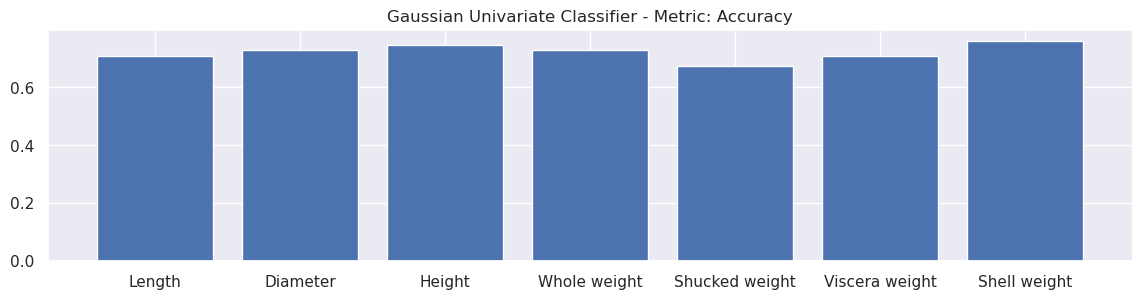

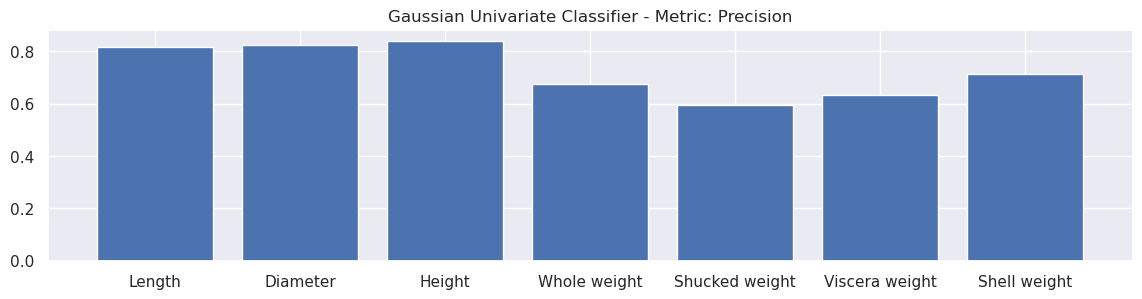

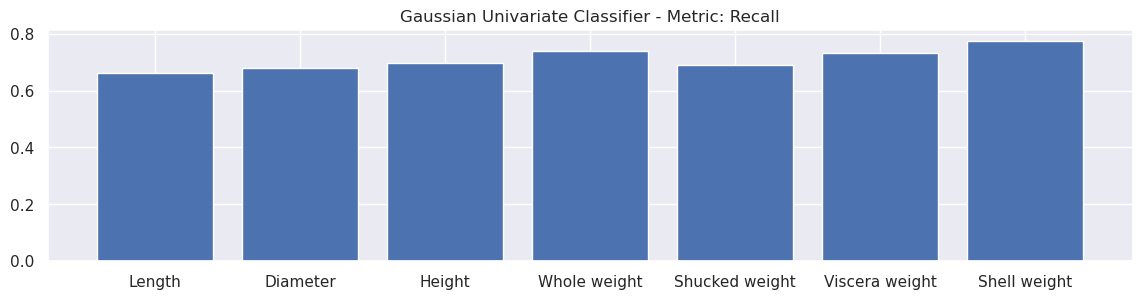

In [9]:
for metric in clfs_metrics_df.index:
    features_metric = clfs_metrics_df.loc[metric]
    plt.figure(figsize=(14, 3))
    plt.title("Gaussian Univariate Classifier - Metric: " + str(metric))
    plt.bar(clfs_metrics_df.columns, features_metric)
plt.show()


It seems quite difficult to decide which one is better because of the similarity of the charts above. So we may better select the mean of each classifier's performances, namely:

In [10]:
best_ft = clfs_metrics_df.mean(0).idxmax()
best_ft


'Height'

### Posterior probability curves and decision boundaries

We saw the the feature that produced the best univariate classifier was `Height`, now let's visualize the curves for the posterior probability for each class and the decision boundary for this classifier:

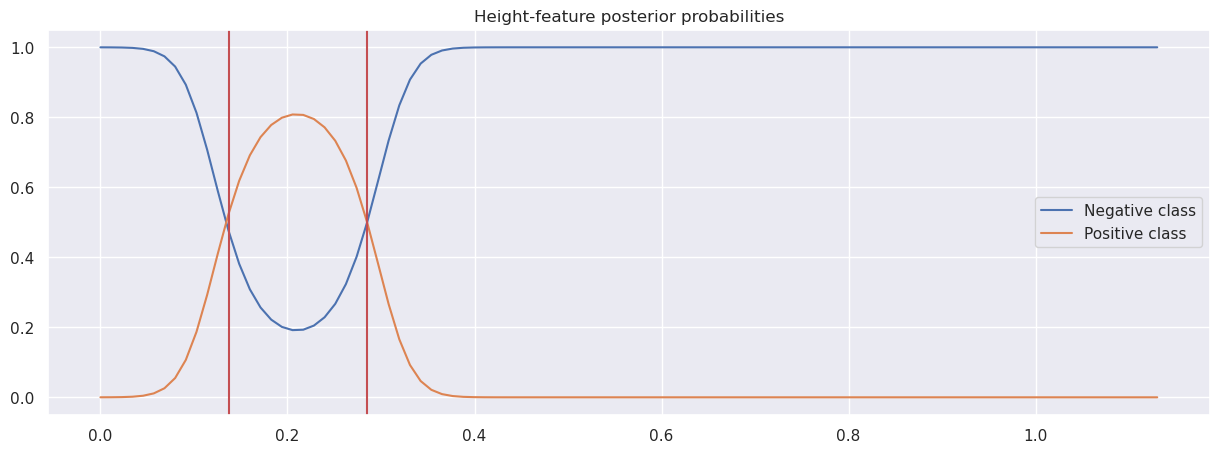

In [11]:
# train classifier on the best feature
best_ft_idx = list(feature_names).index(best_ft)
X_ft = X[:, [best_ft_idx]]
clf = GaussianClassifier()
clf.fit(X_ft, y)

xs = np.linspace(X_ft.min(), X_ft.max(), 100).reshape(-1, 1)
probs = clf.predict_proba(xs)
probs_negative = probs[:, 0]
probs_positive = probs[:, 1]

# decision boundaries
left_bound = np.where(probs_negative < probs_positive)[0][0]
right_bound = np.where((probs_positive < probs_negative) == False)[0][-1] + 1

plt.figure(figsize=(15, 5))
plt.title(f"{best_ft}-feature posterior probabilities")
plt.plot(xs.reshape(-1), probs_negative, label="Negative class")
plt.plot(xs.reshape(-1), probs_positive, label="Positive class")
plt.axvline(x=xs[left_bound], color="r")
plt.axvline(x=xs[right_bound], color="r")
plt.legend()
plt.show()


# 2nd Point

Our approach to the solution to this problem is as follows:

- Create 3 dataframes accuracy_df, precision_df & recall_df in order to compute the performance of the models generated by each possible combination of tow features using the same GaussianClassifier() class built before.

- Plot these dataframes and use a third one average_df (Which averages those dataframes values) in order to chose the best model.

## a) Bivariate Model & Parameter Estimation

In [12]:
# metric dataframes
accuracy_df = pd.DataFrame(index=feature_names, columns=feature_names, dtype=float)
precision_df = pd.DataFrame(index=feature_names, columns=feature_names, dtype=float)
recall_df = pd.DataFrame(index=feature_names, columns=feature_names, dtype=float)

for ft1, ft1_name in enumerate(feature_names):
    for ft2, ft2_name in enumerate(feature_names):
        if ft2 <= ft1:
            continue
        # train bivariate gaussian classifier
        X_tr_fts = X_train[:, [ft1, ft2]]
        X_tst_fts = X_test[:, [ft1, ft2]]
        clf = GaussianClassifier()
        clf.fit(X_tr_fts, y_train)

        # Set the covariance matrix to a constant identity
        unique_var = X_tr_fts.var()
        clf.cov = np.stack([np.diag([unique_var, unique_var]) for _ in range(2)], 0)

        # make predictions
        y_pred = clf.predict(X_tst_fts)

        # calculate performance metrics
        accuracy_df.loc[ft1_name, ft2_name] = accuracy_score(y_pred, y_test)
        precision_df.loc[ft1_name, ft2_name] = precision_score(y_pred, y_test)
        recall_df.loc[ft1_name, ft2_name] = recall_score(y_pred, y_test)


## b) Performance - Bivariate models

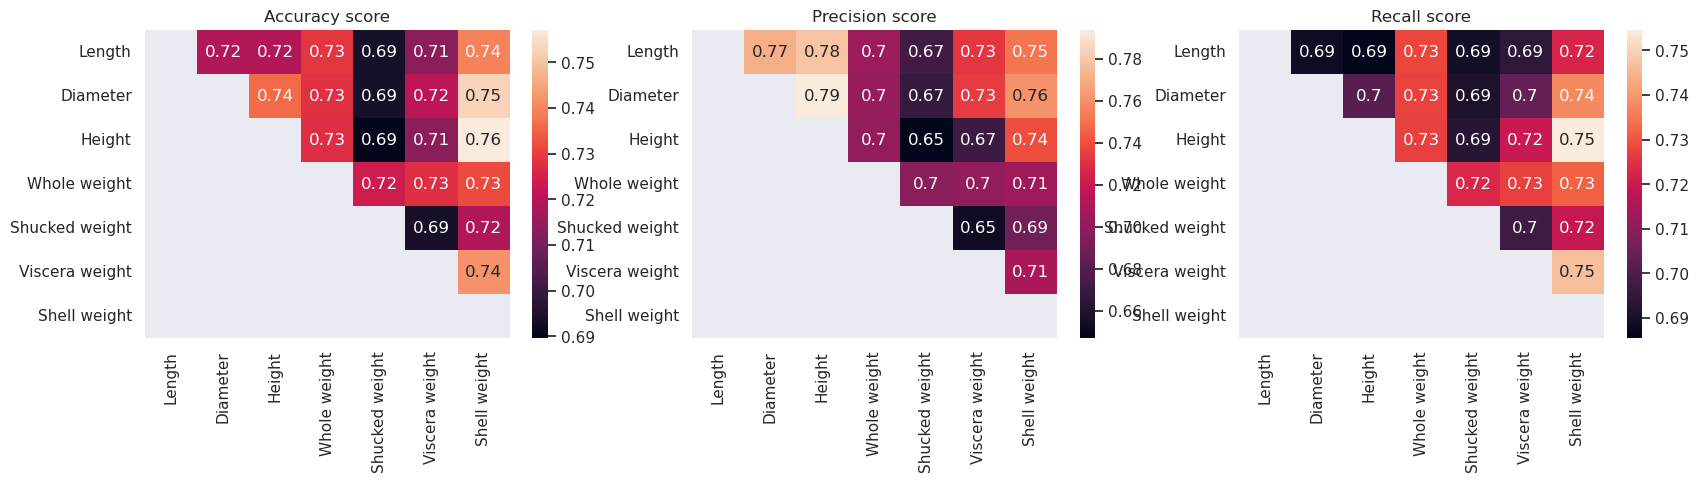

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))

# Create a heatmap of the accuracy_df and add it to the first column of the figure
sns.heatmap(accuracy_df, ax=axs[0], annot=True)
axs[0].set_title("Accuracy score")

# Create a heatmap of the precision_df and add it to the second column of the figure
sns.heatmap(precision_df, ax=axs[1], annot=True)
axs[1].set_title("Precision score")

# Create a heatmap of the recall_df and add it to the third column of the figure
sns.heatmap(recall_df, ax=axs[2], annot=True)
axs[2].set_title("Recall score")

# Show the figure
plt.show()


We conjecture that the combination of the features Shell weight and Height generates the best Gaussian model: In the above viz we observed that in both Accuracy & Recall this combination has the best performance and performs well in the Precision with respect the others. Let's prove this conjecture, averaging the scores:

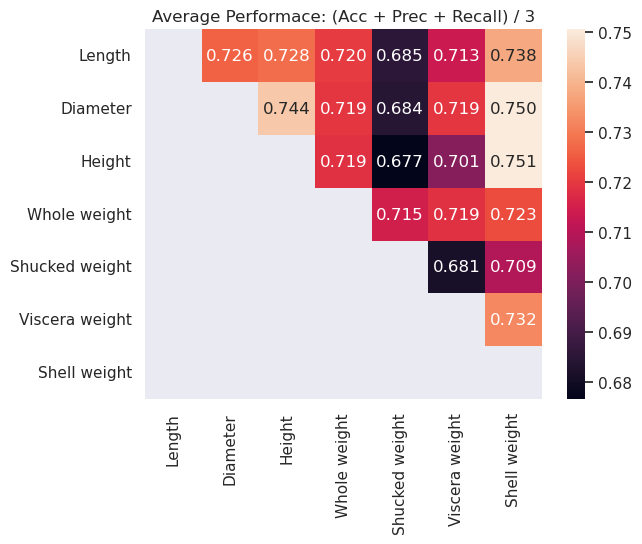

In [14]:
average_df = (accuracy_df + precision_df + recall_df) / 3
sns.heatmap(average_df, annot=True, fmt=".3f")
plt.title("Average Performace: (Acc + Prec + Recall) / 3")

plt.show()


Conclusion:  In the previous visualizations we observed that the bivariate model that uses the features combination Shell weight and Height performs better. 

## c) ROC Curves

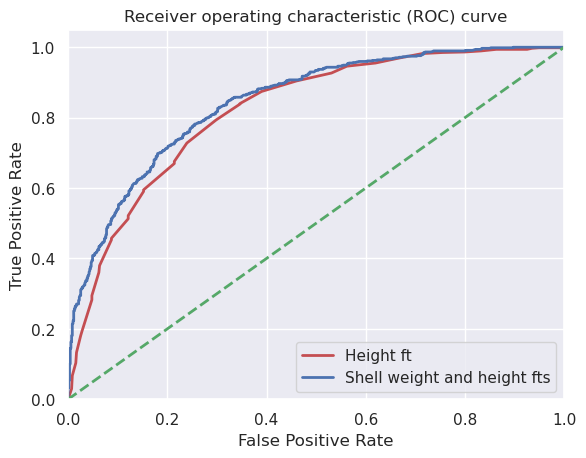

In [15]:
# univariate gaussian classifier with best feature
best_ft_idx = list(feature_names).index(best_ft)
X_train_ft = X_train[:, [best_ft_idx]]
X_test_ft = X_test[:, [best_ft_idx]]

# train classifier
clf = GaussianClassifier()
clf.fit(X_train_ft, y_train)
y_pred_uni = clf.predict_proba(X_test_ft)

# compute false positive and true positive rates
fpr_uni, tpr_uni, thresholds_uni = roc_curve(y_test, y_pred_uni[:, 1])

# bivariate gaussian classifier with best pair of features
ft1 = list(feature_names).index("Height")
ft2 = list(feature_names).index("Shell weight")
X_train_fts = X_train[:, [ft1, ft2]]
X_test_fts = X_test[:, [ft1, ft2]]

# train classifier
clf = GaussianClassifier()
clf.fit(X_train_fts, y_train)

# set the covariance matrix to a constant identity
unique_var = X_train_fts.var()
clf.cov = np.stack([np.diag([unique_var, unique_var]) for _ in range(2)], 0)
y_pred_bi = clf.predict_proba(X_test_fts)

# compute false positive and true positive rates
fpr_bi, tpr_bi, thresholds_bi = roc_curve(y_test, y_pred_bi[:, 1])

# plot ROC curves for both univariate and bivariate classifiers
plt.plot(fpr_uni, tpr_uni, color="r", lw=2, label="Height ft")
plt.plot(fpr_bi, tpr_bi, color="b", lw=2, label="Shell weight and height fts")
plt.plot([0, 1], [0, 1], color="g", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (ROC) curve")
plt.legend(loc="lower right")
plt.show()


Conclusion: From the above ROC curves, we to conclude that the best bivariate model performs better than the best univariate model.

# 3rd Point

The following function helps us plot the decision regions:

In [16]:
import matplotlib.patches as mpatches


def plot_decision_regions(
    X,
    y,
    classifier,
    title="Decision regions",
    x_an=None,
    y_an=None,
    show_points=False,
    resolution=0.02,
    show_analytical=False,
) -> None:

    """Plot decision regions for a classifier.

    Args:
        X (numpy.ndarray): Features to plot.
        y (numpy.ndarray): Class labels for the features.
        classifier (object): Classifier object with a predict method.
        title (str, optional): Title for the plot. Defaults to 'Decision regions'.
        x_an (numpy.ndarray, optional): X-coordinates of analytical decision boundary. Defaults to None.
        y_an (numpy.ndarray, optional): Y-coordinates of analytical decision boundary. Defaults to None.
        show_points (bool, optional): Whether to show data points. Defaults to False.
        resolution (float, optional): Resolution for the meshgrid. Defaults to 0.02.
        show_analytical (bool, optional): Whether to show analytical decision boundary. Defaults to False.

    Returns:
        None.
    """
    labels = ["0", "1", "Reject"]
    # Set up marker generator and color map
    markers = ("o", "x", "s", "^", "v")
    colors = ("red", "blue", "lightgreen", "gray", "cyan")
    n_classes = 3 if classifier.reject_lambda is not None else len(np.unique(y))
    cmap = ListedColormap(colors[:n_classes])
    plt.figure(figsize=(7, 7))

    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution)
    )
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot class samples
    if show_points:
        for idx, cl in enumerate(np.unique(y)):
            plt.scatter(
                x=X[y == cl, 0],
                y=X[y == cl, 1],
                alpha=0.2,
                c=colors[idx],
                marker=markers[idx],
                label=cl,
            )
        plt.legend(loc="upper left")

    # Plot analytical decision boundary
    if show_analytical:
        title = "Analytical decision boundary"
        plt.plot(x_an, y_an, linewidth=5, color="yellow", label="Decision boundary")
        plt.legend()

    # Set plot labels and title
    plt.xlabel("Height")
    plt.ylabel("Shell weight")
    plt.title(title)
    plt.legend(
        handles=[
            mpatches.Patch(color=color, label=label)
            for color, label in zip(colors[:n_classes], labels[:n_classes])
        ]
    )
    plt.show()


## a) Decision Regions

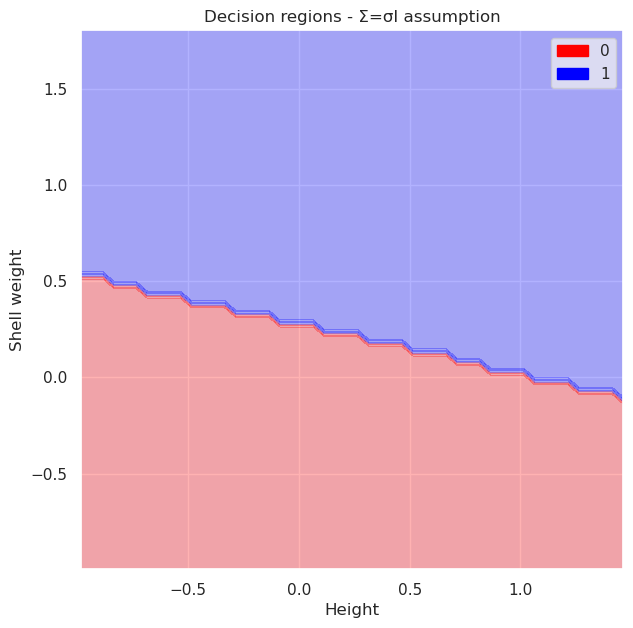

In [17]:
# bivariate gaussian classifier with best features
ft1 = list(feature_names).index("Height")  # index of "Height" feature
ft2 = list(feature_names).index("Shell weight")  # index of "Shell weight" feature

X_train_fts = X_train[
    :, [ft1, ft2]
]  # get training data with only the two best features
X_test_fts = X_test[:, [ft1, ft2]]  # get testing data with only the two best features

# train Gaussian classifier on the training data
clf = GaussianClassifier()
clf.fit(X_train_fts, y_train)

unique_var = (
    X_train_fts.var()
)  # calculate the variance of the two features in the training data
clf.cov = np.stack(
    [np.diag([unique_var, unique_var]) for _ in range(2)], 0
)  # set the covariance matrix of the classifier

# plot decision regions for the test data using the trained classifier
plot_decision_regions(
    X_test_fts, y_test, clf, resolution=0.05, title="Decision regions - Σ=σI assumption"
)


## b) Analytical Decision Boundaries

In [18]:
print(
    "Covariance matrix (Σ = σI for every class) \n {} \n\n Mean array - Class 0: \n {} \n\n Mean array - Class 1: \n {}".format(
        clf.cov[0], clf.means[0], clf.means[0]
    )
)


Covariance matrix (Σ = σI for every class) 
 [[0.0133869 0.       ]
 [0.        0.0133869]] 

 Mean array - Class 0: 
 [0.11909452 0.16014322] 

 Mean array - Class 1: 
 [0.11909452 0.16014322]


### Lemma 3.1 [Discriminant function]

The discriminant function **g(x)** for two multinormal-distributed classes (ignoring the normalization term $\mathbb{P}(x)$)) is:

$$
\begin{aligned}
g(x) = \frac{1}{\sigma\sqrt{2\pi}}(e^{-\frac{1}{2}(\big(\frac{x-\mu_{(0,0)}}{\sigma}\big)^2+\big(\frac{x-\mu_{(1,0)}}{\sigma}\big)^2)}\mathbb{P}(C_0) - e^{-\frac{1}{2}(\big(\frac{x-\mu_{(0,1)}}{\sigma}\big)^2+\big(\frac{x-\mu_{(1,1)}}{\sigma}\big)^2)}\mathbb{P}(C_1))
\end{aligned}
$$

Where $\mu_{(f,c)}$ := Mean of the date accross the $f$th feature ($f=0,1$) for the $c$th class ($c=0, 1$)

**Proof:**  Since there are two classes, we can define the single determinant function 


$$
\begin{aligned}
    g(x) &= g_0(x) - g_1(x) \\
    \quad &= \mathbb{P}(C_0|x) - \mathbb{P}(C_1|x) \\
    \quad &= \mathbb{P}(C_0)\mathbb{P}(x|C_0) - \mathbb{P}(C_1)\mathbb{P}(x|C_1) \quad\quad(\text{Ignoring the normalization term }  \mathbb{P}(x)) \\
    &= \frac{1}{\sigma\sqrt{2\pi}}(e^{-\frac{1}{2}(\big(\frac{x-\mu_{(0,0)}}{\sigma}\big)^2+\big(\frac{x-\mu_{(1,0)}}{\sigma}\big)^2)}\mathbb{P}(C_0) - e^{-\frac{1}{2}(\big(\frac{x-\mu_{(0,1)}}{\sigma}\big)^2+\big(\frac{x-\mu_{(1,1)}}{\sigma}\big)^2)}\mathbb{P}(C_1))
\end{aligned}
$$
$$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\blacksquare $$

### Lemma 3.2 [Solution to bivariate quadratic equation]

Let be $L, a, b, c\in\mathbb{R}$ and $x, y\in\mathbb{C}$. Suppose that 

$$
\begin{aligned}(x-a)^2+(y-b)^2 -(x-c)^2-(y-d)^2= L
\end{aligned}
$$

Then 
$$y = \alpha x+\beta$$

Where 
- $\alpha = \frac{a-c}{d-b}$
- $\beta = \frac{L+c^2+d^2-a^2-b^2}{2(d-b)}$

**Proof**: Since 

$$
\begin{aligned}
(x-a)^2+(y-b)^2 -(x-c)^2-(y-d)^2= L
\end{aligned}
$$

Then,

$$
\begin{aligned}
x^2 - 2ax + a^2 + y^2 - 2by + b^2 - x^2 + 2cx - c^2 - y^2 + 2dy - d^2 = L
\end{aligned}
$$

Hence,

$$
\begin{aligned}
-2ax + 2cx - 2by + 2dy + a^2 - b^2 - c^2 + d^2 = L
\end{aligned}
$$

Thus,

$$
\begin{aligned}
x(-2a+2c) + y(-2b+2d) + (a^2-b^2-c^2+d^2) = L
\end{aligned}
$$

And finally 

$$
\begin{aligned}
y = \alpha x+\beta
\end{aligned}
$$

for the same $\alpha$ and $\beta$  stated in the preposition.

$$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\blacksquare $$                                                                                             

### Proposition [Analytical decision boundary]

 The analytical decision boundary for the problem above is given by 

$$
\begin{aligned}
\{(x_0, x_1)| x_1 = \frac{\mu_{(1,1)} - \mu_{(0,1)}}{\mu_{(1,0)} - \mu_{(0,0)}} x_0 + \frac{1}{2(\mu_{(1,0)} - \mu_{(0,0)})} \Bigg(-2\sigma^2 \ln\Bigg(\frac{\mathbb{P}(C_1)}{\mathbb{P}(C_0)}\Bigg)+ \mu_{(0,1)}^2 + \mu_{(1,1)}^2 - \mu_{(0,0)}^2 - \mu_{(1,0)}^2\Bigg)\}
\end{aligned}
$$ 

**Proof:** Our goal is to find the set of points $x\in\mathbb{R}^2$ such that the discriminant function $g(x)$ is equal to 0. From **Lemma 3.1**, the discriminant function is defined by:

$$
\begin{aligned}
g(x) = \frac{1}{\sigma\sqrt{2\pi}}(e^{-\frac{1}{2}(\big(\frac{x-\mu_{(0,0)}}{\sigma}\big)^2+\big(\frac{x-\mu_{(1,0)}}{\sigma}\big)^2)}\mathbb{P}(C_0) - e^{-\frac{1}{2}(\big(\frac{x-\mu_{(0,1)}}{\sigma}\big)^2+\big(\frac{x-\mu_{(1,1)}}{\sigma}\big)^2)}\mathbb{P}(C_1))
\end{aligned}
$$

So our goal is translated to find the set of points $x\in\mathbb{R}^2$ such that 

$$
\begin{aligned}
\frac{1}{\sigma\sqrt{2\pi}}(e^{-\frac{1}{2}(\big(\frac{x-\mu_{(0,0)}}{\sigma}\big)^2+\big(\frac{x-\mu_{(1,0)}}{\sigma}\big)^2)}\mathbb{P}(C_0) - e^{-\frac{1}{2}(\big(\frac{x-\mu_{(0,1)}}{\sigma}\big)^2+\big(\frac{x-\mu_{(1,1)}}{\sigma}\big)^2)}\mathbb{P}(C_1))=0
\end{aligned}
$$

multiplying  both hands by $\sigma\sqrt{2\pi}$ we obtain,

$$
\begin{aligned}
e^{-\frac{1}{2}(\big(\frac{x-\mu_{(0,0)}}{\sigma}\big)^2+\big(\frac{x-\mu_{(1,0)}}{\sigma}\big)^2)}\mathbb{P}(C_0) - e^{-\frac{1}{2}(\big(\frac{x-\mu_{(0,1)}}{\sigma}\big)^2+\big(\frac{x-\mu_{(1,1)}}{\sigma}\big)^2)}\mathbb{P}(C_1)=0
\end{aligned}
$$

Or equivalently,

$$
\begin{aligned}
e^{-\frac{1}{2}(\big(\frac{x-\mu_{(0,0)}}{\sigma}\big)^2+\big(\frac{x-\mu_{(1,0)}}{\sigma}\big)^2)}\mathbb{P}(C_0) = e^{-\frac{1}{2}(\big(\frac{x-\mu_{(0,1)}}{\sigma}\big)^2+\big(\frac{x-\mu_{(1,1)}}{\sigma}\big)^2)}\mathbb{P}(C_1)
\end{aligned}
$$

Applyng $$ln(.)$$ to both hands we get,

$$
\begin{aligned}
-\frac{1}{2}(\big(\frac{x-\mu_{(0,0)}}{\sigma}\big)^2+\big(\frac{x-\mu_{(1,0)}}{\sigma}\big)^2) + ln(\mathbb{P}(C_0)) = -\frac{1}{2}(\big(\frac{x-\mu_{(0,1)}}{\sigma}\big)^2+\big(\frac{x-\mu_{(1,1)}}{\sigma}\big)^2) + ln(\mathbb{P}(C_1))
\end{aligned}
$$

Organizing terms:

$$
\begin{aligned}
\frac{1}{2}(\big(\frac{x-\mu_{(0,1)}}{\sigma}\big)^2+\big(\frac{x-\mu_{(1,1)}}{\sigma}\big)^2)-\frac{1}{2}(\big(\frac{x-\mu_{(0,0)}}{\sigma}\big)^2-\big(\frac{x-\mu_{(1,0)}}{\sigma}\big)^2)  =  ln(\frac{\mathbb{P}(C_1)}{\mathbb{P}(C_0)})
\end{aligned}
$$

$$
\begin{aligned}
(x-\mu_{(0,0)})^2+(x-\mu_{(1,0)})^2 -(x-\mu_{(0,1)})^2-(x-\mu_{(1,1)})^2= -2\sigma \ln(\frac{\mathbb{P}(C_1)}{\mathbb{P}(C_0)})
\end{aligned}
$$

Applying **Lemma 3.2**, we conclude that:

$$
\begin{aligned}
x_1 = \frac{\mu_{(0,0)} - \mu_{(0,1)}}{\mu_{(1,1)} - \mu_{(1,0)}} x_0 + \frac{-2\sigma^2\log(P_1/P_0) + \mu_{(0,1)}^2 + \mu_{(1,1)}^2 - \mu_{(0,0)}^2 - \mu_{(1,0)}^2}{2(\mu_{(1,1)} - \mu_{(1,0)})}
\end{aligned}
$$

$$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\blacksquare$$  

Lets compute the solution for the values gotten in our problem

In [19]:
# Problem values
mu_00 = clf.means[0][0]
mu_10 = clf.means[0][1]
mu_01 = clf.means[1][0]
mu_11 = clf.means[1][1]
sigma = clf.cov[0][0][0]

# A priori probabilities
p0 = clf.priors[0]
p1 = clf.priors[1]

# Line equation constants for our problem
alpha = (mu_00 - mu_01) / (mu_11 - mu_10)
beta = (
    (-2 * sigma**2 * np.log(p1 / p0))
    + (mu_01**2 + mu_11**2 - mu_00**2 - mu_10**2)
) / (2 * (mu_11 - mu_10))

# View how is defined the line equation
print("Line equation:    y={}x+{}".format(alpha, beta))


Line equation:    y=-0.2588477740005141x+0.2767620285854089


### Plot the line equation

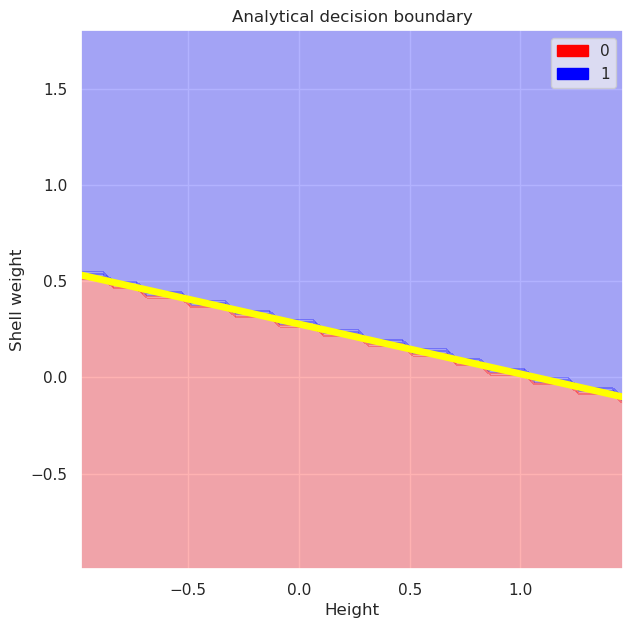

In [20]:
# Define the x and y ranges for plotting the decision boundary
x = np.linspace(-1.0, 1.5, 100)
y = alpha * x + beta

# Determine the indices of the two features to use for training and testing
ft1 = list(feature_names).index("Height")
ft2 = list(feature_names).index("Shell weight")

# Subset the training and testing data to only include the selected features
X_train_fts = X_train[:, [ft1, ft2]]
X_test_fts = X_test[:, [ft1, ft2]]

# Instantiate the GaussianClassifier and fit it to the training data
clf = GaussianClassifier()
clf.fit(X_train_fts, y_train)

# Set the covariance of the classifier to a diagonal matrix with unique_var along the diagonal
unique_var = X_train_fts.var()
clf.cov = np.stack([np.diag([unique_var, unique_var]) for _ in range(2)], 0)

# Plot the decision regions and training/test data points
plot_decision_regions(
    X=X_test_fts,
    y=y_test,
    classifier=clf,
    x_an=x,
    y_an=y,
    resolution=0.05,
    show_analytical=True,
)


# 4th Point

## a) Covariance Matrix

In [21]:
# Bivariate Gaussian classifier using the best features
# Find the index of the column "Height" in the feature_names list
ft1 = list(feature_names).index("Height")

# Find the index of the column "Shell weight" in the feature_names list
ft2 = list(feature_names).index("Shell weight")

# Select the columns corresponding to the two best features
X_tr_fts = X_train[:, [ft1, ft2]]
X_tst_fts = X_test[:, [ft1, ft2]]

# Initialize and fit the Gaussian classifier using the training data
clf = GaussianClassifier()
clf.fit(X_tr_fts, y_train)


## b) Decision Regions

/tmp/ipykernel_14903/3984292154.py:85: RuntimeWarning: invalid value encountered in divide
  posteriors /= posteriors.sum(1, keepdims=True)


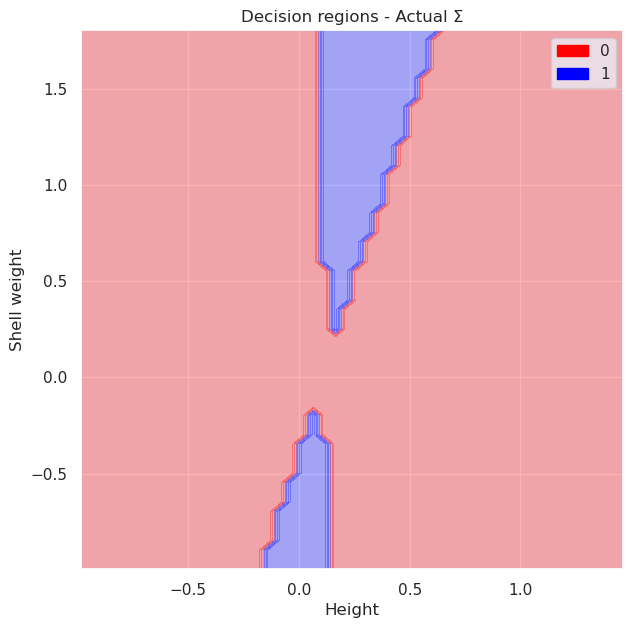

In [22]:
plot_decision_regions(
    X_tst_fts, y_test, clf, resolution=0.05, title="Decision regions - Actual Σ"
)  # Decision boundary with real covariance matrix


**Comparison with point 3 regions**: Since we remove the naive assumption $\Sigma=\sigma I$. We observed that the decision regions change a lot. We know MVN's pdf depends strongly on $\Sigma$ (Its rank, determinant and inverse). So it is not so difficult to notica that the likelihoods will actually change drastically and since the original $\Sigma$ is used, the predictions are naturally better.

## c) Rejection assumption

In [23]:
# Bivariate Gaussian classifier using the best features
# Find the index of the column "Height" in the feature_names list
ft1 = list(feature_names).index("Height")

# Find the index of the column "Shell weight" in the feature_names list
ft2 = list(feature_names).index("Shell weight")

# Select the columns corresponding to the two best features
X_tr_fts = X_train[:, [ft1, ft2]]
X_tst_fts = X_test[:, [ft1, ft2]]

# Initialize and fit the Gaussian classifier using the training data
clf = GaussianClassifier(reject_lambda=0.8)
clf.fit(X_tr_fts, y_train)


/tmp/ipykernel_14903/3984292154.py:85: RuntimeWarning: invalid value encountered in divide
  posteriors /= posteriors.sum(1, keepdims=True)


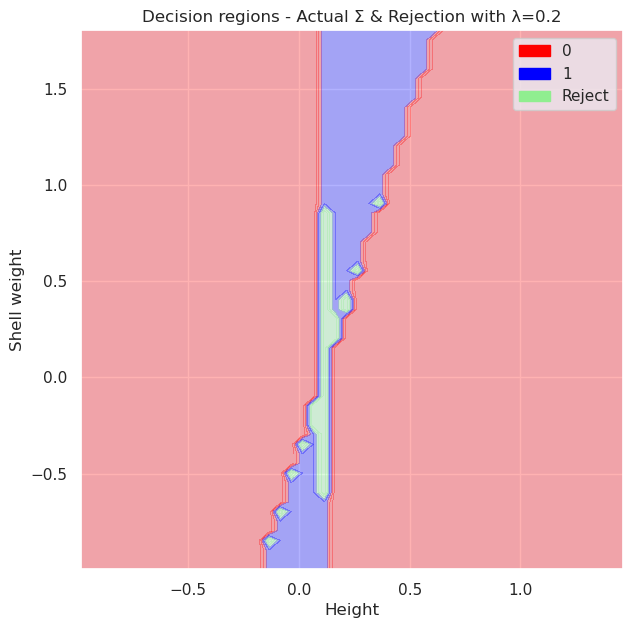

In [24]:
# Bivariate Gaussian classifier using the best features
# Find the index of the column "Height" in the feature_names list
ft1 = list(feature_names).index("Height")

# Find the index of the column "Shell weight" in the feature_names list
ft2 = list(feature_names).index("Shell weight")

# Select the columns corresponding to the two best features
X_tr_fts = X_train[:, [ft1, ft2]]
X_tst_fts = X_test[:, [ft1, ft2]]

# Initialize and fit the Gaussian classifier using the training data
clf = GaussianClassifier(reject_lambda=0.2)
clf.fit(X_tr_fts, y_train)

# Decision boundary with real covariance matrix
plot_decision_regions(
    X_tst_fts,
    y_test,
    clf,
    resolution=0.05,
    title="Decision regions - Actual Σ & Rejection with λ=0.2",
)


# References

$[$Alp14$]$ Alpaydin, E. $\textit{Introduction to Machine Learning}$, 3Ed. The MIT Press, 2014\
$[$DHS00$]$ Duda, R. O., Hart, P. E., and Stork, D. G. 2000 $\textit{Pattern Classification}$ (2nd Edition). Wiley-Interscience.